In [1]:
from pathlib import Path
import sys

sys.path.append(str(Path('').absolute().parent))

In [2]:
import joblib
import numpy as np
import seaborn as sns
import shap
from scipy import sparse
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report
)
from sklearn.utils.validation import check_is_fitted

# Paths

In [3]:
ROOT = Path('..')
MODELS_DIR = ROOT / 'models'
DATA_DIR = ROOT / 'data'
RAW_DATA_DIR = DATA_DIR / 'raw'

# Load data splits

In [4]:
# TODO: move to utils
def load_data_splits(*, data_dir, split):
    if split not in ['train', 'test']:
        raise ValueError('`split` should be either `train` or `test`')
    
    X = sparse.load_npz(data_dir / split / f'sparse_{split}_X.npz')\
        .toarray()
    y = sparse.load_npz(data_dir / split / f'sparse_{split}_y.npz')\
        .toarray()\
        .squeeze()
    
    return X, y

In [5]:
train_X, train_y = load_data_splits(data_dir=RAW_DATA_DIR, split='train')
test_X, test_y = load_data_splits(data_dir=RAW_DATA_DIR, split='test')

# print shapes to confirm
for split in ['train_X', 'train_y', 'test_X', 'test_y']:
    print('{name}: {shape}'.format(name=split, shape=eval(split).shape))

train_X: (4140, 2048)
train_y: (4140,)
test_X: (1035, 2048)
test_y: (1035,)


# Load best model

In [6]:
best_model_path = MODELS_DIR / 'model_gb.joblib'
model = joblib.load(best_model_path)
check_is_fitted(model)
model

GradientBoostingClassifier(learning_rate=0.3935910935564404, max_depth=14,
                           min_samples_leaf=17, n_estimators=155,
                           random_state=123)

In [7]:
model_tuned_params = dict(
    learning_rate=0.3935911,
    max_depth=14,
    min_samples_leaf=17,
    n_estimators=155,
    random_state=123
)

# Benchmark performance on test set

In [8]:
test_pred = model.predict(test_X)
print('Accuracy on test set: {:.4f}'.format(accuracy_score(test_y, test_pred)))
print(classification_report(test_y, test_pred))

Accuracy on test set: 0.8406
              precision    recall  f1-score   support

           0       0.76      0.72      0.74       324
           1       0.88      0.90      0.89       711

    accuracy                           0.84      1035
   macro avg       0.82      0.81      0.81      1035
weighted avg       0.84      0.84      0.84      1035



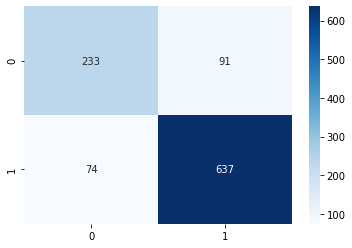

In [9]:
sns.heatmap(confusion_matrix(test_y, test_pred),
            cmap='Blues', annot=True, fmt='d');

# Using SHAP for explanations

In [10]:
def get_top_bits(shap_values, n):
    importances = np.abs(shap_values).mean(0)
    return list(reversed(np.argsort(importances)))[:n]

## On test features

In [11]:
feature_names = [*map(lambda x: 'bit_{}'.format(x),
                      range(test_X.shape[1]))]
explainer = shap.Explainer(model,
                           feature_names=feature_names)
shap_explanation = explainer(train_X)

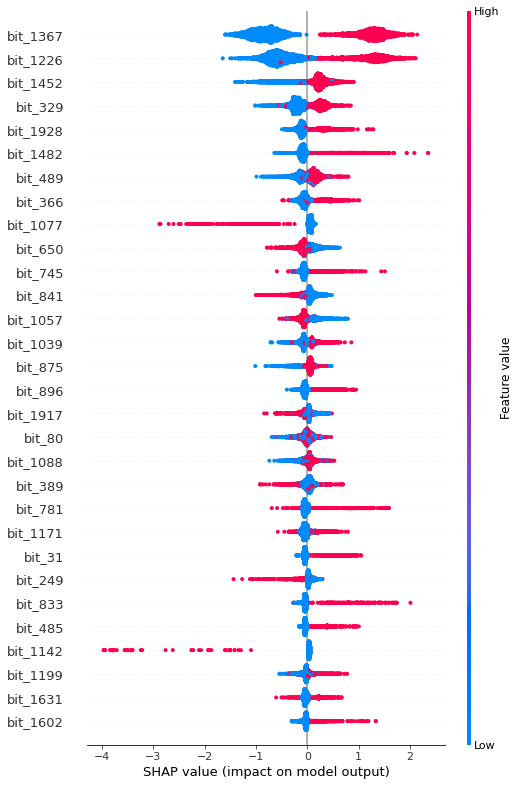

In [12]:
# nummary_plot explaining target class at index 0
shap.summary_plot(shap_explanation, train_X, max_display=30)

### Bar plot
Summarize the effects of features accross all instances

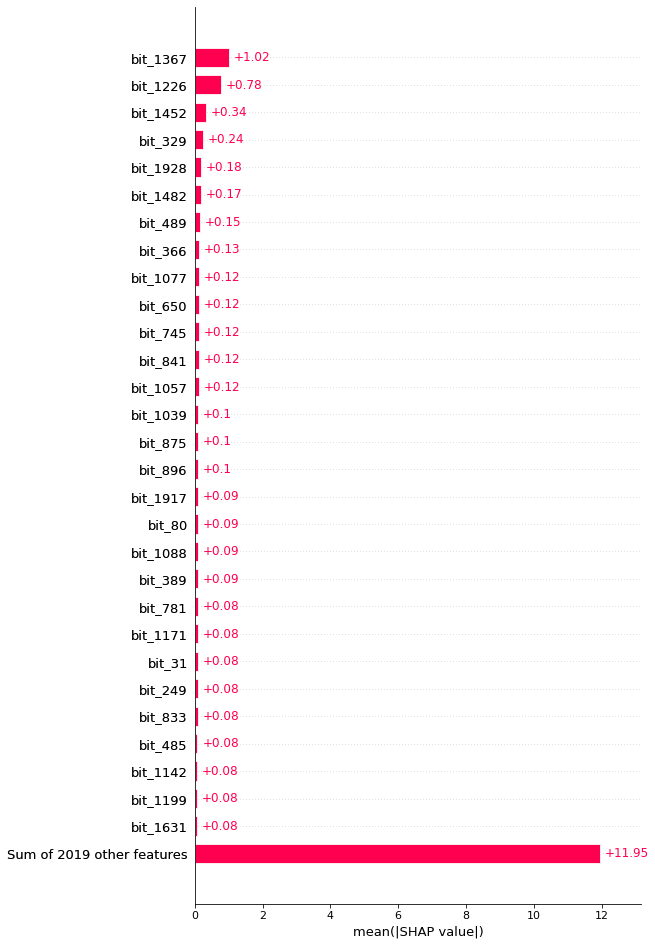

In [13]:
shap.plots.bar(shap_explanation, max_display=30)

As expected from ensembles (specially boosted trees), feature contributions "add up" to get a prediction result. Hence, the overall contribution of each feature tends to be small, and spread across many of them. However, in this scenario we clearly have two features standind out.

In [14]:
top_10_bits = get_top_bits(shap_explanation.values, n=10)
top_10_bits

[1367, 1226, 1452, 329, 1928, 1482, 489, 366, 1077, 650]

In [21]:
import h5py
from scripts.preprocessing import selection_by_threshold
from scripts.morgan_handler import get_morgan_fingerprints

morgan_fp, df_labels = get_morgan_fingerprints()

#Removes bits that never appear in the fingerprints
clean_df_discard, dropped_labels = selection_by_threshold('incidence', morgan_fp, (1/(len(morgan_fp) + 1)))

#Gets importance values and list them
importances = np.abs(shap_explanation.values).mean(0)
importances_list = list(reversed(np.argsort(importances)))

#Remove bits that never appear in the fingerprints from the importance list
for item in importances_list:
    if item in dropped_labels:
        importances_list.remove(item)
        
lower_10_bits = importances_list[-1:-10:-1]
lower_10_bits

[1193, 1192, 1191, 1189, 1188, 1187, 1186, 1185, 1198]

# Visualize most important bits as molecule fragments

In [22]:
import json
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import (Draw,
                        Descriptors,
                        AllChem)
import pandas as pd

In [23]:
df_smiles = pd.read_csv(DATA_DIR / 'egfr_erbB1_smiles.csv', index_col=0)
df_smiles.head()

,chembid,smiles_notation
0,CHEMBL301018,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OC
1,CHEMBL281543,C=CC(=O)Nc1nc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc1CCCCN...
2,CHEMBL401930,Cc1cc(N2CCOCC2)cc2[nH]c(-c3c(NC[C@@H](O)c4cccc...
3,CHEMBL274654,Cc1[nH]c(/C=C2\C(=O)Nc3ccccc32)c(C)c1CCC(=O)O
4,CHEMBL382822,COc1cc2ncnc(Nc3cccc(Cl)c3F)c2cc1CN1CCC[C@@H]1C...


In [24]:
with open(DATA_DIR / 'bit_info.json', 'r') as file:
    chembl_to_bitinfo = json.load(file)

print('Sample elem from map:')
[{k: v} for k, v in chembl_to_bitinfo.items()][0]

Sample elem from map:


{'CHEMBL301018': {'191': [[10, 1]],
  '216': [[12, 2]],
  '249': [[1, 2], [21, 2]],
  '329': [[10, 2]],
  '366': [[15, 1]],
  '378': [[5, 0], [7, 0]],
  '465': [[13, 2]],
  '489': [[6, 1]],
  '491': [[9, 1]],
  '561': [[16, 1]],
  '673': [[4, 2]],
  '695': [[1, 0], [21, 0]],
  '699': [[14, 1]],
  '708': [[8, 1]],
  '780': [[3, 2]],
  '794': [[8, 2]],
  '841': [[0, 1], [22, 1]],
  '843': [[11, 2]],
  '875': [[3, 1], [19, 1], [17, 1]],
  '888': [[9, 2]],
  '1057': [[0, 0], [22, 0]],
  '1097': [[4, 1]],
  '1152': [[9, 0]],
  '1157': [[18, 2]],
  '1226': [[5, 2]],
  '1245': [[2, 2], [20, 2]],
  '1357': [[18, 1]],
  '1367': [[7, 2]],
  '1380': [[2, 0],
   [4, 0],
   [8, 0],
   [10, 0],
   [13, 0],
   [15, 0],
   [18, 0],
   [20, 0]],
  '1452': [[5, 1], [7, 1]],
  '1488': [[15, 2]],
  '1536': [[1, 1], [21, 1]],
  '1581': [[17, 2]],
  '1648': [[19, 2]],
  '1683': [[16, 0]],
  '1750': [[11, 1], [12, 1]],
  '1810': [[6, 2]],
  '1840': [[13, 1]],
  '1873': [[3, 0], [6, 0], [11, 0], [12, 0], [17,

In [25]:
# funções de conveniência
def get_mol(chembl, df_smiles):
    smiles = df_smiles[df_smiles['chembid'] == chembl].iloc[0,1]
    mol = Chem.MolFromSmiles(smiles)
    return mol

# Agrupamento considerando apenas principais bits

In [116]:
import math
def safe_ratio(x,y):
    if y == 0:
        return math.nan
    else:
        return ((x/y))

In [117]:
inhibitor_fp_list = []
non_inhibitor_fp_list = []

for fp, label in zip(morgan_fp, df_labels['labels']):
    if label == 1:
        inhibitor_fp_list.append(fp)
    else:
        non_inhibitor_fp_list.append(fp)
        
inhibitor_fp_array = np.array(inhibitor_fp_list)
non_inhibitor_fp_array = np.array(non_inhibitor_fp_list)

In [120]:
inhibitor_incidence = np.sum(inhibitor_fp_array, axis = 0)/len(inhibitor_fp_array)
non_inhibitor_incidence = np.sum(non_inhibitor_fp_array, axis =0)/len(non_inhibitor_fp_array)

incidence_ratio = []

for bit in range(0,2048):
    incidence_ratio.append(safe_ratio(inhibitor_incidence[bit], non_inhibitor_incidence[bit]))

In [121]:
top_bit_inhibitor_incidence = []
top_bit_non_inhibitor_incidence = []
top_ratio = []

lower_bit_inhibitor_incidence = []
lower_bit_non_inhibitor_incidence = []
lower_ratio = []


for bit in top_10_bits:
    top_bit_inhibitor_incidence.append(inhibitor_incidence[bit])
    top_bit_non_inhibitor_incidence.append(non_inhibitor_incidence[bit])
    top_ratio.append(safe_ratio(inhibitor_incidence[bit], non_inhibitor_incidence[bit]))

top_bit = pd.DataFrame({'top_10_bits': top_10_bits, 'inhib_incidence':top_bit_inhibitor_incidence, 
                        'non_inhib_incidence':top_bit_non_inhibitor_incidence, 'ratio':top_ratio})

for bit in lower_10_bits:
    lower_bit_inhibitor_incidence.append(inhibitor_incidence[bit])
    lower_bit_non_inhibitor_incidence.append(non_inhibitor_incidence[bit])  
    lower_ratio.append(safe_ratio(inhibitor_incidence[bit], non_inhibitor_incidence[bit]))

lower_bit = pd.DataFrame({'lower_10_bits': lower_10_bits, 'inhib_incidence':lower_bit_inhibitor_incidence, 
                        'non_inhib_incidence':lower_bit_non_inhibitor_incidence, 'ratio':lower_ratio})

In [122]:
top_bit

,top_10_bits,inhib_incidence,non_inhib_incidence,ratio
0,1367,0.550239,0.122072,4.507515
1,1226,0.464115,0.114673,4.047281
2,1452,0.809738,0.460543,1.758227
3,329,0.507458,0.158446,3.202715
4,1928,0.311849,0.152898,2.039594
5,1482,0.129468,0.045623,2.837800
6,489,0.634393,0.248459,2.553316
7,366,0.293836,0.124538,2.359417
8,1077,0.028990,0.090629,0.319871
9,650,0.558401,0.662145,0.843321


Bit 1367 ----------------------------------------------


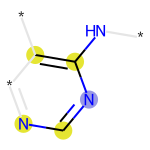

Bit 1226 ----------------------------------------------


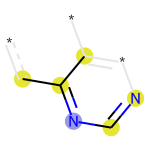

Bit 1452 ----------------------------------------------


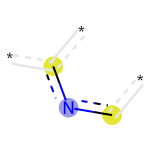

Bit 329 -----------------------------------------------


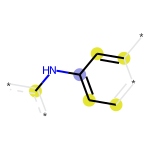

Bit 1928 ----------------------------------------------


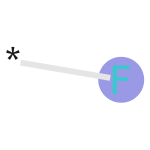

Bit 1482 ----------------------------------------------


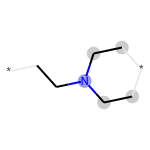

Bit 489 -----------------------------------------------


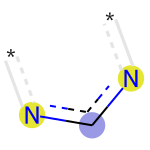

Bit 366 -----------------------------------------------


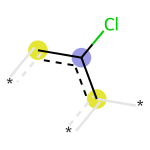

Bit 1077 ----------------------------------------------


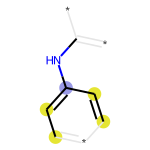

Bit 650 -----------------------------------------------


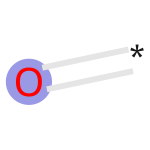

In [123]:
for bit_num in top_10_bits:
    search_bit = str(bit_num)
    print('Bit {}'.format(search_bit), '-'*(50 - len(search_bit)))

    # get bit info corresponding to it
    chemblid, bi = [(_id, bit_info) for _id, bit_info in chembl_to_bitinfo.items()
                    if search_bit in list(bit_info.keys())][0]
    
    search_mol = get_mol(chemblid, df_smiles)
    bit_img = Draw.DrawMorganBit(search_mol, search_bit, bi, useSVG=True)
    display(bit_img)

In [124]:
lower_bit.sort_values(by= 'ratio', ascending = False)

,lower_10_bits,inhib_incidence,non_inhib_incidence,ratio
3,1189,0.005629,0.000617,9.130312
6,1186,0.004503,0.001233,3.652125
1,1192,0.003096,0.001233,2.510836
7,1185,0.001970,0.001233,1.597805
4,1188,0.003659,0.004316,0.847815
8,1198,0.002815,0.004932,0.570645
2,1191,0.000844,0.002466,0.342387
5,1187,0.002252,0.006782,0.332011
0,1193,0.010695,0.000000,NaN


Bit 1193 ----------------------------------------------


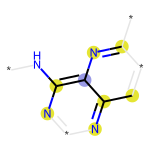

Bit 1192 ----------------------------------------------


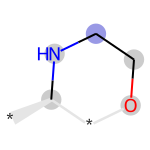

Bit 1191 ----------------------------------------------


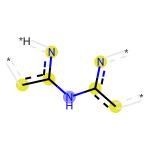

Bit 1189 ----------------------------------------------


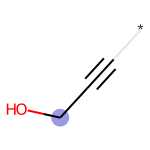

Bit 1188 ----------------------------------------------


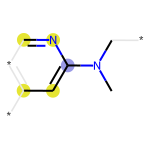

Bit 1187 ----------------------------------------------


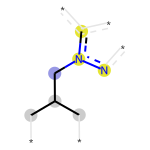

Bit 1186 ----------------------------------------------


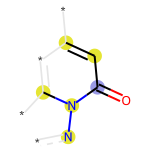

Bit 1185 ----------------------------------------------


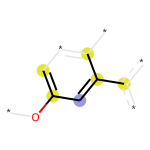

Bit 1198 ----------------------------------------------


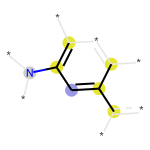

In [126]:
for bit_num in lower_10_bits:
    search_bit = str(bit_num)
    print('Bit {}'.format(search_bit), '-'*(50 - len(search_bit)))

    # get bit info corresponding to it
    chemblid, bi = [(_id, bit_info) for _id, bit_info in chembl_to_bitinfo.items()
                    if search_bit in list(bit_info.keys())][0]
    
    search_mol = get_mol(chemblid, df_smiles)
    bit_img = Draw.DrawMorganBit(search_mol, search_bit, bi, useSVG=True)
    display(bit_img)

In [156]:
bits = range(0,2048)
df_diff = pd.DataFrame({'bit':bits, 'inhibitor_incidence':inhibitor_incidence, 
                        'non_inhibitor_incidence':non_inhibitor_incidence,
                       'incidence_ratio':incidence_ratio})

In [164]:
null_ratio_df = df_diff[(df_diff['incidence_ratio'] == 0)]
sorted_null_ratio_df = null_ratio_df.sort_values(by= 'non_inhibitor_incidence', ascending = False, ignore_index = True)
non_inhibiting_bits = sorted_null_ratio_df[0:10:1]['bit']

Bit 1247 ----------------------------------------------


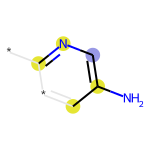

Bit 604 -----------------------------------------------


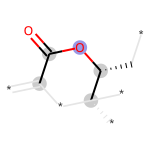

Bit 1904 ----------------------------------------------


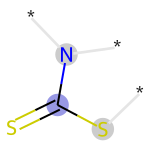

Bit 1115 ----------------------------------------------


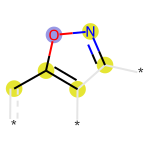

Bit 17 ------------------------------------------------


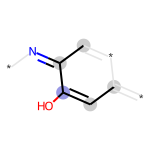

Bit 1371 ----------------------------------------------


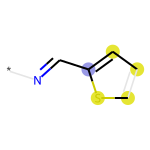

Bit 1438 ----------------------------------------------


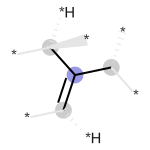

Bit 545 -----------------------------------------------


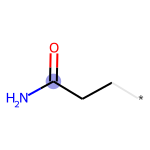

Bit 856 -----------------------------------------------
Bit 1606 ----------------------------------------------


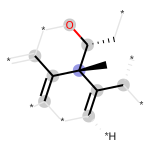

In [165]:
for bit_num in non_inhibiting_bits:
    search_bit = str(bit_num)
    print('Bit {}'.format(search_bit), '-'*(50 - len(search_bit)))

    # get bit info corresponding to it
    chemblid, bi = [(_id, bit_info) for _id, bit_info in chembl_to_bitinfo.items()
                    if search_bit in list(bit_info.keys())][0]
    
    search_mol = get_mol(chemblid, df_smiles)
    try:
        bit_img = Draw.DrawMorganBit(search_mol, search_bit, bi, useSVG=True)
        display(bit_img)
    except:
        pass